In [1]:
# ----🍃Step0: Load Dataset🍃-----
import pandas as pd
import numpy as np
rawData =pd.read_csv('fitbod_ZENGLi_20200811-175932.csv')

In [2]:
#visulization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
 
sns.set_style("whitegrid")
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.fontsize='15'

In [3]:
#machine learning
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

# 🍃Part1: Understand the New Dataset

In [5]:
# ------Part1.1: Check the data type and summary statistics------
print("------------- Basic Data Information -------------")
rawData.info()

------------- Basic Data Information -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24892 entries, 0 to 24891
Data columns (total 8 columns):
Date            24892 non-null object
workoutId       24892 non-null object
exerciseId      24892 non-null object
singleSetId     24892 non-null object
exerciseName    24892 non-null object
reps            24892 non-null int64
weight          24892 non-null float64
fake_user_id    24892 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB


In [6]:
#Summary Stats for Numerical Data Types
rawData.describe()

,reps,weight
count,24892.000000,24892.000000
mean,8.512454,41.947573
std,3.796801,32.520648
min,1.000000,0.000000
25%,5.000000,15.875752
50%,8.000000,29.483539
75%,10.000000,61.235043
max,40.000000,192.776987


Let's start looking if reps and weight counts have a normal distribuition

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


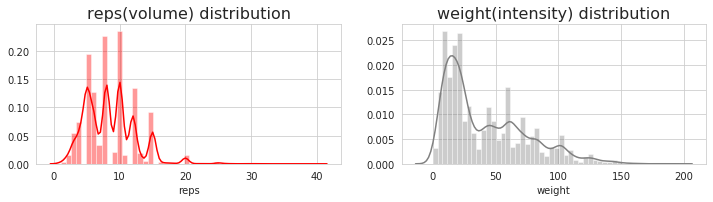

In [7]:
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(rawData['reps'],color='red')
g1.set_title("reps(volume) distribution", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(rawData['weight'],color='grey')
g2.set_title('weight(intensity) distribution', fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()

non-normal distribution, if later I use those attributes, I may transform into normal (i.e., square root transformation) for later ML models

In [8]:
#Summary Stats for Categorical Data Types 
rawData.describe(include=['O'])

,Date,workoutId,exerciseId,singleSetId,exerciseName,fake_user_id
count,24892,24892,24892,24892,24892,24892
unique,366,5221,9,24838,9,132
top,2019-11-13,bW2miN8az5,mnwUcsbS9T,BBMFkp2wnU,Barbell Bench Press,fake_id_596
freq,171,20,4314,2,4314,1163


Looking the exerciseName distribuition by category_name's

In [10]:
df_temp2 = rawData[['workoutId','fake_user_id','exerciseName']].groupby(['exerciseName','fake_user_id'], as_index=True).agg({'workoutId':pd.Series.nunique})
df_temp2=df_temp2.reset_index()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


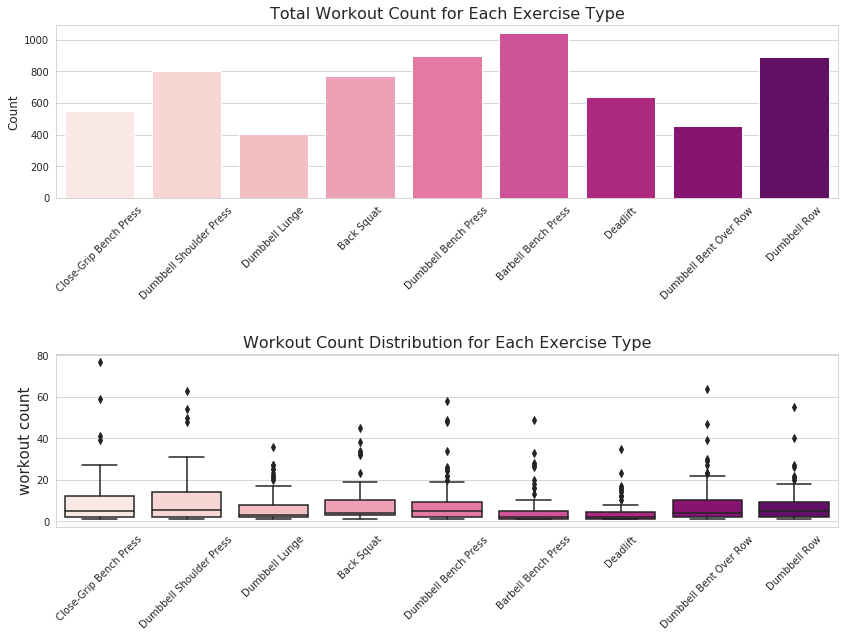

In [11]:
#get the data
plt.figure(figsize = (14,9))
df_temp1=rawData[['workoutId','exerciseName']].drop_duplicates()
df_temp2 = rawData[['workoutId','fake_user_id','exerciseName']].groupby(['exerciseName','fake_user_id'], as_index=True).agg({'workoutId':pd.Series.nunique})
df_temp2=df_temp2.reset_index()
df_temp2.columns=['exerciseName','fake_user_id','workout_count']
df_temp3 = df_temp2[['exerciseName','workout_count']]

#visulization
plt.subplot(211)
g = sns.countplot('exerciseName', data=df_temp1, palette="RdPu")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Total Workout Count for Each Exercise Type", fontsize=16)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxplot(x='exerciseName', y='workout_count', data=df_temp3, palette="RdPu")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Workout Count Distribution for Each Exercise Type", fontsize=16)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("workout count", fontsize=15)

plt.subplots_adjust(hspace = 0.9, top = 0.9)

plt.show()

Insights:

(1) Barbell Bench Press is mostly popular and frequently chosen by Fitbod users.


(2) The outliers of all exercise types are concentrated on the larger value side, meaning the distribution is right skewed. In addition, the degree of deviation is different for different exercise types. (can try log transformation, square transformation or just increase the samples!)

(3) Users can be divided into different groups according to their workout frequencies, low (<50%), medium(50%-75%), high(75%-100%), strong(outliers). Note that those strong users(outliers) will produce significant to mean values.

(4) Although Berbell Bench Press has some strong lovers, most users will try few times.


In [12]:
#-------Part1.2: Check the Missing Value-----
missing =rawData.replace(" ",np.nan)
total_missing = missing.isnull().sum().sort_values(ascending = False)
percent_missing = (missing.isnull().sum()/missing.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_Missing', 'Percent_Missing(%)'])
print("\n-----------Missing Value Analysis--------------\n",missing)


-----------Missing Value Analysis--------------
               Total_Missing  Percent_Missing(%)
fake_user_id              0                 0.0
weight                    0                 0.0
reps                      0                 0.0
exerciseName              0                 0.0
singleSetId               0                 0.0
exerciseId                0                 0.0
workoutId                 0                 0.0
Date                      0                 0.0


Note: No missing value here (No need to delete or fill)

In [14]:
#------1.3 Get some ideas about 'ID'-----------
#Correct understanding about ID relationships will be crucial to later dataframe groupby and pivots!
rawData[["workoutId","exerciseId","singleSetId"]].groupby(['workoutId','exerciseId'], as_index=False).agg(['count'])

singleSetId
                            count
workoutId  exerciseId            
00LcdZFzmC dXqYJgUYO6           3
01QiUChixe mnwUcsbS9T           4
029ZlvyE5z 6REm9Tfqpa           3
           bOhZg3HbGM           3
           mvkMgAdecH           5
...                           ...
zwxwU530Pv 6REm9Tfqpa           4
           h85ZOw37Wc           4
zxEU3x1Ho6 52vo7F7CLd           4
zyUHIjZmmD mvkMgAdecH           5
zzUVkJ6kij G1mxtZtEs5           4

[6451 rows x 1 columns]

🔥 For one person, his every workout can include different exerciseId and sigleSetId.

🔥 One workoutId and one exercise ID will correspond to severl singleSetId: data from each set is logged seperately in one exercise. 

In [17]:
#Verify the relationship I have inferred using group by and distinct count
check2=rawData[["workoutId","exerciseId","singleSetId",'fake_user_id','Date']].groupby(['singleSetId'], as_index=False).agg({'fake_user_id':pd.Series.nunique, 'exerciseId': pd.Series.nunique,
                                                                                                                        'workoutId': pd.Series.nunique,
                                                                                                                            'Date': pd.Series.nunique})
check2.head(8)

,singleSetId,fake_user_id,exerciseId,workoutId,Date
0,00LkZPW7Rt,1,1,1,1
1,00UlWoagR6,1,1,1,1
2,013CKMya8S,1,1,1,1
3,014RYrZ2l2,1,1,1,1
4,01AMR3FeqH,1,1,1,1
5,01GOCYcPlk,1,1,1,1
6,01LNzGQXLt,1,1,1,1
7,01OaMGK2CA,1,1,1,1


It seems singleSetId can be unique to identify each user activity in this dataset.

In [19]:
check2.describe()

,fake_user_id,exerciseId,workoutId,Date
count,24838.0,24838.0,24838.000000,24838.0
mean,1.0,1.0,1.002174,1.0
std,0.0,0.0,0.046577,0.0
min,1.0,1.0,1.000000,1.0
25%,1.0,1.0,1.000000,1.0
50%,1.0,1.0,1.000000,1.0
75%,1.0,1.0,1.000000,1.0
max,1.0,1.0,2.000000,1.0


⚠️ singleSetId is not unique as I found for the same singleSetId, there are maximized 2 workoutId (maybe more but 2 for the current dataset)

In [20]:
#❓Find the reason why there are more than 1 record for one singleSetID, if the dataset is correct
check=rawData[["workoutId","exerciseId","singleSetId"]].groupby(['singleSetId'], as_index=False).agg(['count'])
check = check[(check['workoutId']['count'] != 1)]
check.head(5)

,workoutId,exerciseId
,count,count
singleSetId,,
0nq0TVi34d,2,2
1so1Rc5o1p,2,2
2zNsd8eCq1,2,2
3yfSIQpPW2,2,2
657tEio54T,2,2


In [21]:
rawData[(rawData['singleSetId']=='3yfSIQpPW2')]

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
18707,2019-12-05,zjQcEcp0di,mnwUcsbS9T,3yfSIQpPW2,Barbell Bench Press,4,102.058405,fake_id_598
24181,2019-12-05,GqT0FiCS1E,mnwUcsbS9T,3yfSIQpPW2,Barbell Bench Press,4,102.058405,fake_id_598


In [22]:
#❓Check user bahavior for repeated singleSetId
rawData[(rawData['fake_user_id']=='fake_id_598') &(rawData['Date']=='2019-12-05')]

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
2375,2019-12-05,GqT0FiCS1E,mnwUcsbS9T,pyK6kXIIMM,Barbell Bench Press,10,92.986546,fake_id_598
4501,2019-12-05,zjQcEcp0di,mnwUcsbS9T,pyK6kXIIMM,Barbell Bench Press,10,92.986546,fake_id_598
13557,2019-12-05,zjQcEcp0di,mnwUcsbS9T,WarLyjB8ph,Barbell Bench Press,12,83.914688,fake_id_598
18707,2019-12-05,zjQcEcp0di,mnwUcsbS9T,3yfSIQpPW2,Barbell Bench Press,4,102.058405,fake_id_598
20973,2019-12-05,GqT0FiCS1E,mnwUcsbS9T,i7HAd4srCb,Barbell Bench Press,8,83.914688,fake_id_598
22470,2019-12-05,GqT0FiCS1E,mnwUcsbS9T,WarLyjB8ph,Barbell Bench Press,12,83.914688,fake_id_598
22819,2019-12-05,zjQcEcp0di,mnwUcsbS9T,i7HAd4srCb,Barbell Bench Press,8,83.914688,fake_id_598
24181,2019-12-05,GqT0FiCS1E,mnwUcsbS9T,3yfSIQpPW2,Barbell Bench Press,4,102.058405,fake_id_598


🔥 Suggest that if one user repeats the same exercise set in one day, BUT in two different workouts, this will be recorded as one singleSetId under two different workoutIds! (can be recognized as the repeat behavior)

# 🍃Part2: Explanatroy Data Analysis

# Step0: Motivation to Create the User Churn Prediction Model

In [43]:
#-----New Users Analysis------
rawData =pd.read_csv('fitbod_ZENGLi_20200811-175932.csv')
df_all = rawData[['Date','fake_user_id']].drop_duplicates()
df_user=user_basic_portrait (rawData)
df_user = df_user[['first_use_date','fake_user_id']].drop_duplicates()
df_merge = pd.merge(df_all, df_user, on='fake_user_id', how='left')
total_user_day = df_merge[['Date',"fake_user_id"]].groupby(['Date'], as_index=False).agg(['count'])

#total users per day
total_user_day=total_user_day.reset_index()
total_user_day.columns=['Date','total_users']
total_user_day

#new users per day
def function(m, n):
    if m == n:
        return 1
    else:
        return 0
df_merge['new_users'] = df_merge.apply(lambda x : function(x['Date'],x['first_use_date']),axis = 1)

new_user_day = df_merge[['Date','new_users']].groupby(['Date'], as_index=False).agg(['sum'])
new_user_day=new_user_day.reset_index()
new_user_day.columns=['Date','new_users']
new_user_day

#merge
df_merge2 = pd.merge(total_user_day, new_user_day, on='Date', how='left')
df_merge2['new_percentage']=df_merge2['new_users']/df_merge2['total_users']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


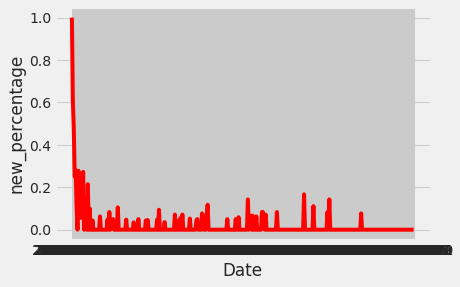

In [45]:
df=df_merge2[['Date','new_percentage']]
sns.lineplot(x = "Date", y = "new_percentage",c='red',data = df)

(1) Hard for Fitbod to acquire new users as they covered a very small portion in daily active users, in that case it will be more important to retain our existing customers and make the churn rate as low as possible! 

(2) It will be helpful to build a churn prediction model to predict the possible churn users in the future and make corresponding actions before they finally leave Fitbod!

# Prediction about New User Rate over the Next Period

In [46]:
def time_fb(time_data,forcast_time_window):
    time_data.columns=['ds', 'y']
    time_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    model=time_prophet.fit(time_data)
    time_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    model=time_prophet.fit(time_data)
    time_forecast = model.make_future_dataframe(periods=365 * 1, freq='D')
    time_forecast = time_prophet.predict(time_forecast)
    fig = model.plot_components(time_forecast)
    return(model.plot(time_forecast, xlabel = 'Date', ylabel = 'existing_and_predicted value'))
    return(fig)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


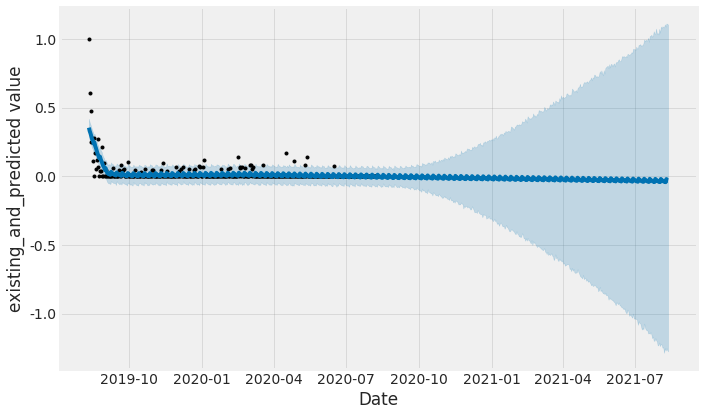

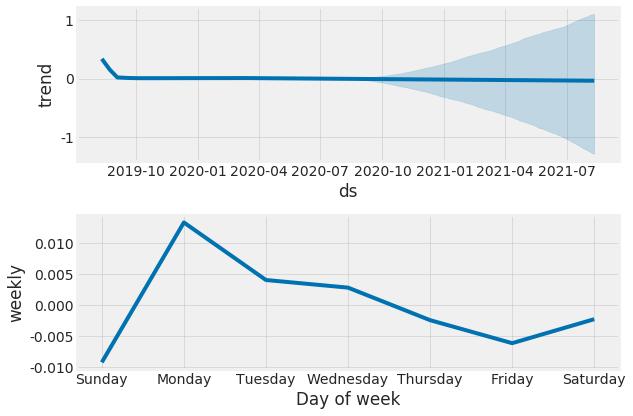

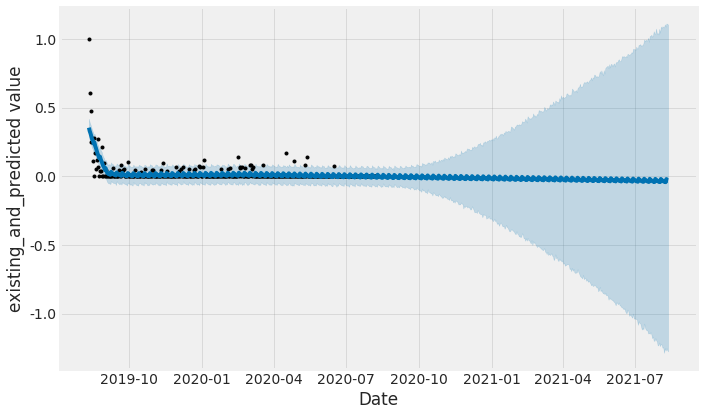

In [47]:
time_fb(df,1)

Very close to zero! If no more new users come to our platform as uncertain Covid-19 situation does NOT get better, our churn model will make an impact for the business!

In [23]:
# Install Related Packages
# Datetime operations
import time
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import warnings
warnings.filterwarnings("ignore")

# Step1: Determine the Best Time Window for the Churn Prediction Model

Time Window:

(1) Determine the Observation Time Window (time period to get users' behaviour data before he stays or leave Fitbod's app)

(2) Determine the Performance Time Window (after the observation time window, this time period is to lable whether user belongs to the 'churn user')

Usage for ML: Once we get the users' behaviour data for the certain observation time window, we can predict whether the user will churn or stay active on Fitbod.

In [24]:
#----DateTime Parsing----
import datetime
rawData['Date']=rawData['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))
rawData['Date_month']=rawData['Date'].apply(lambda x:datetime.datetime.strftime(x,'%m'))
#consider the covid-19, add year_month to distingush with the month
rawData['year_month']=rawData['Date'].apply(lambda x:datetime.datetime.strftime(x,'%y-%m'))
rawData['Date_weekday']=rawData['Date'].apply(lambda x:datetime.datetime.strftime(x,'%w'))

# （1）Active Users Analysis (over time)

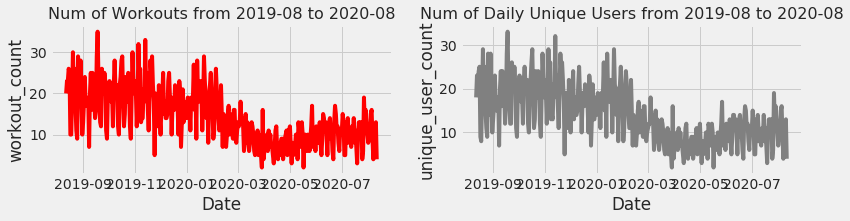

In [26]:
#Daily/Monthly Active Users
df1 = rawData[['Date','workoutId']].groupby(['Date'], as_index=True).agg({'workoutId':pd.Series.nunique})
df1=df1.reset_index()
df1.columns=['Date','workout_count']

df2 = rawData[['Date','fake_user_id']].drop_duplicates()
df2 = rawData[['Date','fake_user_id']].groupby(['Date'], as_index=True).agg({'fake_user_id':pd.Series.nunique})
df2=df2.reset_index()
df2.columns=['Date','unique_user_count']
df2.to_csv("unique_user.csv",index=False,sep=',')

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.lineplot(x="Date", y="workout_count", data=df1, c='red')
g1.set_title("Num of Workouts from 2019-08 to 2020-08", fontsize=16)

plt.subplot(222)
g2 = sns.lineplot(x="Date", y="unique_user_count", data=df2, c='grey')
g2.set_title("Num of Daily Unique Users from 2019-08 to 2020-08", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()

Insights:

(1) Similar trend for count of workouts and count of unqiue daily users from 2019-08 to 2020-08; The usage of Fitbod reached highest in 2019-10, but continued to decrease after 2020-01;

(2) Most possibly caused by the shutdown of gym due to covid-19 (all the exercise types are equipment needed, which happen in the gym. If I have more exercise types, I will add a dummy variable to indicate whether this exercise is conducted in the gym or living room --> can be used to verify the Covid-19 hypothesis)

(3) The total number of workouts began to rebound after 2020-04 (re-open of some gyms + increase of indoor fitness activity, still can be verified)

<Figure size 1440x432 with 0 Axes>

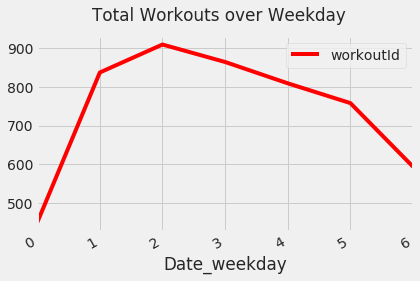

In [27]:
#----Weekly Active Users-------
plt.figure(figsize=(20, 6))
weekday_usage = rawData[['Date_weekday','workoutId']].groupby(['Date_weekday'], as_index=True).agg({'workoutId':pd.Series.nunique})
weekday_usage.plot(subplots = True, title='Total Workouts over Weekday', color='red')
plt.show()

# Active Users Prediction over Time (Later Trend to 2021-8)

In [28]:
#------Active Users Prediction over Time------
#Holiday may cause changes to the workouts change
#Predict the future change with phophet (may need more data as Covid-19 situation contibues to change)
#Advantage: advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints
#!pip install fbprophet
import fbprophet
time_data = rawData[['Date','workoutId']].groupby(['Date'], as_index=False).agg({'workoutId':pd.Series.nunique})
time_data.columns=['ds', 'y']
time_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
model=time_prophet.fit(time_data)


# Make the prophet model and fit on the data
time_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
model=time_prophet.fit(time_data)

## Make a future dataframe for 1 year (because the covid-19 may be controlled after one year, but within this year, the current data will be enough to predict)
time_forecast = model.make_future_dataframe(periods=365 * 1, freq='D')
# Make predictions
time_forecast = time_prophet.predict(time_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Total Number of Workouts')

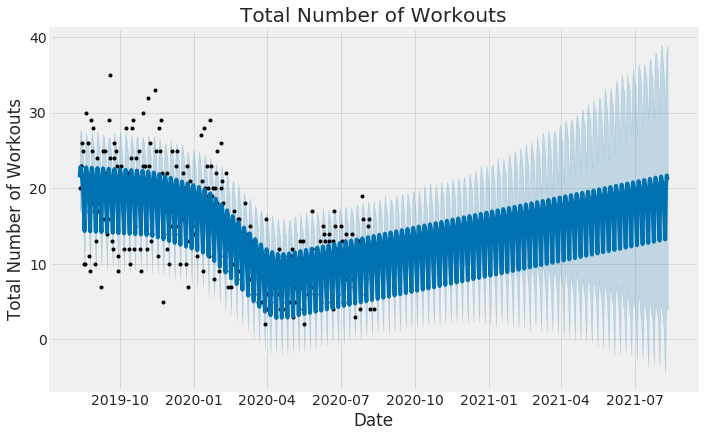

In [29]:
model.plot(time_forecast, xlabel = 'Date', ylabel = 'Total Number of Workouts')
plt.title('Total Number of Workouts')

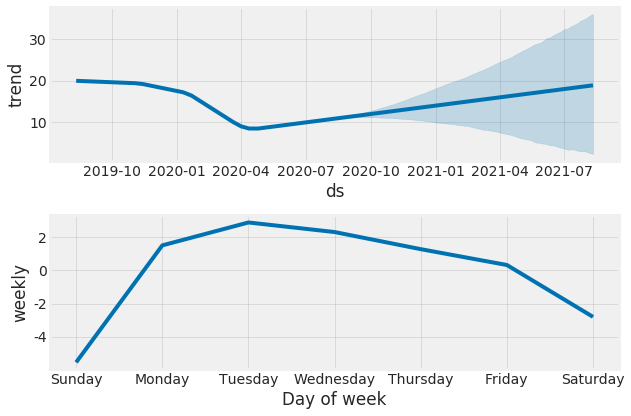

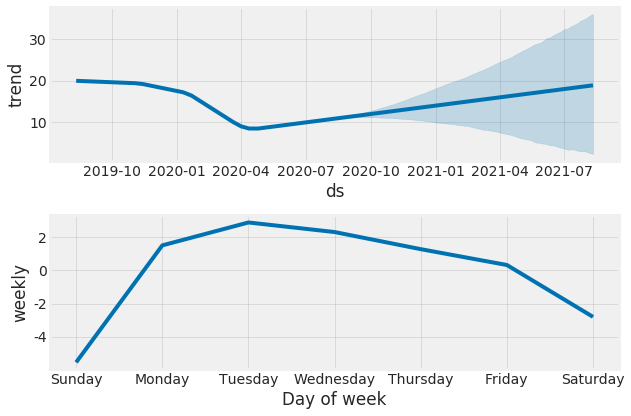

In [30]:
# Plot the trends and patterns
fig = model.plot_components(time_forecast)
fig
#⚠️ lack the timestamp (accurate to hour, can make daily figure);
#⚠️ only have one-year data (fail to make yearly figure)

# Maximum Time Gap (Days) between User's Each Workout (From 2020-04)

I want to determine how many days (time window) I will use to observe users' behaviour as this time should include most of the users who have appeared in the first observation time window.

In [ ]:
df_gap = rawData[['Date','fake_user_id']].drop_duplicates()
df_gap = df_gap[df_gap['Date']>='2020-04-01']
timeDiff=df_gap.assign(rn_time=df_gap.sort_values(['Date'],ascending=True).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
#the next_workout_date
df_next=timeDiff[timeDiff['rn_time']!=1]
df_next=df_next.assign(rn_time=df_next.sort_values(['Date'],ascending=True).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
df_base=df_gap.assign(rn_time=df_gap.sort_values(['Date'],ascending=False).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
df_base=df_base[df_base['rn_time']!=1]
df_base=df_base.assign(rn_time=df_base.sort_values(['Date'],ascending=True).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])

base_next = pd.merge(df_base,df_next, on=['fake_user_id','rn_time'], how='left')

def between_days(first,last):
        i=last-first
        i=i.days
        return(i)
base_next['gap_days'] = base_next.apply(lambda x: between_days(x.Date_x,x.Date_y), axis = 1).to_frame()

#choose the maximized gap_days for each user
base_next_2=base_next.assign(rn_time=base_next.sort_values(['gap_days'],ascending=False).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
base_next_2=base_next_2[base_next_2['rn_time']==1]



#visulization
plt.figure(figsize=[20,15])
plt.subplot(231)
plt.boxplot(x=base_next_2['gap_days'], showmeans = True, meanline = True)
plt.title('max gap day between each workout Boxplot',fontsize=14)
plt.ylabel('gap_days')

plt.subplot(222)
g2 = sns.distplot(base_next_2['gap_days'],color='red')
g2.set_title('max_gap_days for each user distribution', fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()

(1)observation time window: used to observe user's behavior data, here is 60 days, 2020-05-11 to 2020-7-11 (generally will be 60 days, when we have larger dataset to more clearly understand the Fitbod's business request, can better determine this number)

(2)performance time window: used to define and observe user's churn performance data, here is 30 days, 2020-07-11 to 2020-08-11 (since 30 days time window will cover most users whose max gap_days do NOT exceed 30 days )
    
    churn definition: If the user who workouted in the pevious 60 days, but didn't workout more than 5 days in the next 30 days. 
    ⚠️ Note: here I randomply pick 5, BUT this benchmark can be better determined when more data to dertimine: the different value and performance of users to Fitbud's business when they are divided into different cohorts by their workout days in a month (cohort analysis will help!)

In [31]:
#--------data preparation-------
ob_data = rawData[(rawData['Date'] >= '2020-04-11') & (rawData['Date'] < '2020-07-11')]
peform_data = rawData[(rawData['Date'] >= '2020-07-11') & (rawData['Date'] <= '2020-08-11')]
user_list=ob_data['fake_user_id'].tolist()
peform_data= peform_data[peform_data['fake_user_id'].isin(user_list)]

#label the churn user
#total workout times
df2=peform_data[['Date','fake_user_id']].drop_duplicates()
peform_data=df2[["Date","fake_user_id"]].groupby(['fake_user_id'], as_index=False).agg(['count'])
peform_data.columns=['workout_times']

def churn_test(a, benchmark):
    if a >= benchmark:
        return 0
    else:
        return 1
peform_data['churn_user'] =peform_data.apply(lambda x: churn_test(x.workout_times,5), axis = 1)
churn_data =peform_data['churn_user']
#merge data
#ob_peform=pd.merge(ob_data, churn_data, on='fake_user_id',how='left')
#ob_peform.fillna(0, inplace=True)

# Part2.2 Create New Atrributes according User Workout History Data

🔥 Those workout history data can be magically transformed into user fitness portrait data! 

🔥 Later this dataset can be joined with user's basic portrait data (like age, gender, heart rate or other body measurements. Some Fitbod's user data are connected with Apple Health, that's great!)

# (1) User's Basic Fitness Portrait

In [32]:
# Calculate some new metrcis based on existing bahavior data:
def user_basic_portrait (ob_data):
    #（1） User's time related metrixs (Note: ordered time period only in this dataset)
    rawData = ob_data
    df1=rawData[['Date','fake_user_id']].drop_duplicates()
    time_order=df1.assign(rn_time=df1.sort_values(['Date'],ascending=True).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
    #the first use time
    first_use=time_order[time_order['rn_time']==1]
    first_use=first_use.rename(columns={'Date': "first_use_date"})
    first_use=first_use.iloc[:,0:2]
    
    #the last use time
    time_order2=df1.assign(rn_time=df1.sort_values(['Date'],ascending=False).groupby(['fake_user_id']).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_time'])
    last_use=time_order2[time_order2['rn_time']==1]
    last_use=last_use.rename(columns={'Date': "last_use_date"})
    last_use=last_use.iloc[:,0:2]
    
    #merge first and last table
    first_last_use = pd.merge(first_use, last_use, on='fake_user_id', how='left')
    
    #use_days
    active_days=df1[["Date","fake_user_id"]].groupby(['fake_user_id'], as_index=False).agg(['count'])
    user_table = pd.merge(first_last_use, active_days, on='fake_user_id', how='left')
    user_table.columns=['first_use_date','fake_user_id','last_use_date','active_days']
    
    #Exercise Related Metrix
    #total workout times
    df2=rawData[['Date','workoutId','fake_user_id']].drop_duplicates()
    workout_times=df2[["Date",'workoutId',"fake_user_id"]].groupby(['fake_user_id'], as_index=False).agg(['count'])
    workout_times = pd.merge(user_table,workout_times.iloc[:,1], on='fake_user_id', how='left')
    workout_times.columns=['first_use_date','fake_user_id','last_use_date','active_days','workout_times']
    
    #workout_per_day
    workout_times['workout_per_day']=workout_times.iloc[:,-1]/workout_times.iloc[:,-2]
    
    #volume_day: average repeat in workout day
    df3=rawData[['Date','reps','fake_user_id']]
    volume_sum=df3[['reps',"fake_user_id"]].groupby(['fake_user_id'], as_index=False).agg(['sum'])
    volume_day = pd.merge(workout_times,volume_sum, on='fake_user_id', how='left')
    volume_day.columns=['first_use_date','fake_user_id','last_use_date','active_days','workout_times','workout_per_day','volume_total']
    volume_day['volume_per_day']=volume_day.iloc[:,-1]/volume_day.iloc[:,3]
    
    #intensity_day: average weight in workout day
    df4=rawData[['Date','weight','fake_user_id']]
    intensity_sum=df4[['weight',"fake_user_id"]].groupby(['fake_user_id'], as_index=False).agg(['sum'])
    intensity_day = pd.merge(volume_day,intensity_sum, on='fake_user_id', how='left')
    intensity_day.columns=['first_use_date','fake_user_id','last_use_date','active_days','workout_times','workout_per_day','volume_total','volume_per_day',"intensity_total"]
    intensity_day['intensity_per_day']=intensity_day.iloc[:,-1]/intensity_day.iloc[:,3]
    user_info=intensity_day
    
    return(user_info)

In [33]:
user_info=user_basic_portrait(ob_data)

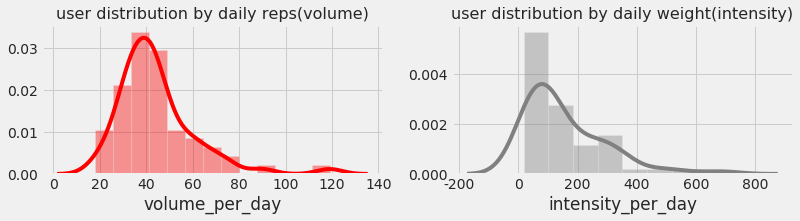

In [34]:
# User Fitness Repeats/Intnsity Distribution
df =user_basic_portrait(ob_data)
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(user_info['volume_per_day'],color='red')
g1.set_title("user distribution by daily reps(volume)", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(user_info['intensity_per_day'],color='grey')
g2.set_title("user distribution by daily weight(intensity)", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()


Non-normal (left skewed); needed to do some transformation before putting into the model;


# (2) User_basic_portrait2: plus active_extent, favorite_exercise, intensity_per_day... 

In [35]:
def user_basic_portrait2(rawData):
    df5=rawData[['Date','workoutId','exerciseName','fake_user_id']]
    # User's Favorite Exericise (the most frequently used)
    exercise_type_sum=df5[['Date','workoutId','exerciseName','fake_user_id']].groupby(['fake_user_id','exerciseName'], as_index=False).agg(['count'])
    df6=exercise_type_sum.reset_index()
    df6.columns=['fake_user_id','exercise_name','date_count','exercise_count']
    exercise_rank=df6.assign(rn_exercise=df6.sort_values(['exercise_count'],ascending=False).groupby(['fake_user_id'],
                                                                                               as_index=False).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_exercise'])
    exercise_rank=exercise_rank.drop(columns=['date_count'])
    user_favorite=exercise_rank[exercise_rank['rn_exercise']==1]
    user_favorite=user_favorite.drop(columns=['exercise_count','rn_exercise'])
    user_info=user_basic_portrait(rawData)
    user_info = pd.merge(user_info,user_favorite, on='fake_user_id', how='left')
    user_info=user_info.rename(columns={"exercise_name": "favorite_exercise"})
    #the most recent exercise
    df7=rawData[['Date','workoutId','exerciseName','fake_user_id']]
    exercise_rank=df7.assign(rn_recent=df7.sort_values(['Date'],ascending=False).groupby(['fake_user_id'],as_index=False).\
                                        cumcount()+1).sort_values(['fake_user_id','rn_recent'])
    recent_exercise=exercise_rank[exercise_rank['rn_recent']==1]
    recent_exercise=recent_exercise.iloc[:,2:4]
    user_info = pd.merge(user_info,recent_exercise, on='fake_user_id', how='left')
    user_info=user_info.rename(columns={"exerciseName": "most_recent_exercise"})
    #stay_days: calculate how many days the users have stay at the platform
    def internal_days(first,last):
        #first=datetime.datetime.strptime(first, '%Y-%m-%d')
        #start=datetime.datetime.strptime(last, '%Y-%m-%d')
        i=last-first
        i=i.days+1
        return(i)
    user_info['stay_days'] = user_info.apply(lambda x: internal_days(x.first_use_date,x.last_use_date), axis = 1).to_frame()
    #active_days_extent: 
    user_info['active_extent']=user_info.iloc[:,4]/user_info.iloc[:,-1]
    
    #how many days pass since user last time used Fitbod?
    user_info['last_to_now']=user_info.apply(lambda x: internal_days(x.last_use_date, datetime.datetime.now()), axis = 1).to_frame()
    user_info['last_to_now']=user_info['last_to_now']-1
    #add two attributes: whether user is high volume/intensity users?
    df_temp=user_info
    volume_mean=df_temp['volume_per_day'].mean(axis=0)
    intensity_mean=df_temp['intensity_per_day'].mean(axis=0)
    def function(a, mean):
        if a >= mean:
            return 1
        else:
            return 0
    df_temp['high_volume_user'] = df_temp.apply(lambda x: function(x.volume_per_day, volume_mean), axis = 1)
    df_temp['high_intensity_user'] = df_temp.apply(lambda x: function(x.intensity_per_day, intensity_mean), axis = 1)
    #add two attributes: Whether User is highly active users?
    #define highly active users: active_extent >= mean, last_to_now <= mean, workout_times >=mean (exclude one-time user)
    df_temp2=df_temp
    active_mean=df_temp2['active_extent'].mean(axis=0)
    last_to_now_mean=df_temp2['last_to_now'].mean(axis=0)
    workout_mean=df_temp2['workout_times'].mean(axis=0)
    def active_test(active_extent, last_to_now, workout_times, mean_a, mean_l, mean_w):
        if (active_extent >= mean_a) and (last_to_now <= mean_l) and (workout_times >=mean_w):
            return (1)
        else:
            return (0)
    
    df_temp2['high_active_user'] = df_temp2.apply(lambda x: active_test(x.active_extent, x.last_to_now,
                                                                   x.workout_times,
                                                                   active_mean,
                                                                   last_to_now_mean,
                                                                  workout_mean), axis = 1)
    return(df_temp2)



In [36]:
#merge data
df_temp=user_basic_portrait2(ob_data)
#merge data
ob_peform=pd.merge(df_temp, churn_data, on='fake_user_id',how='left')
ob_peform.fillna(0, inplace=True)

# Heat Map of Correlation: Pick Possible Important Variables to Churn

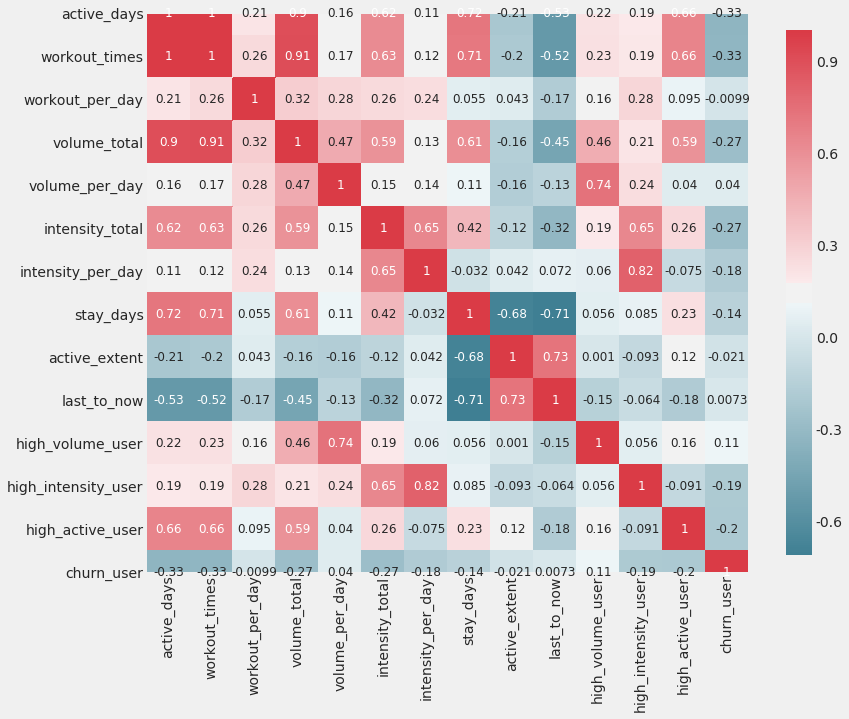

In [37]:
#correlation between attributes
plot_correlation_map(ob_peform)

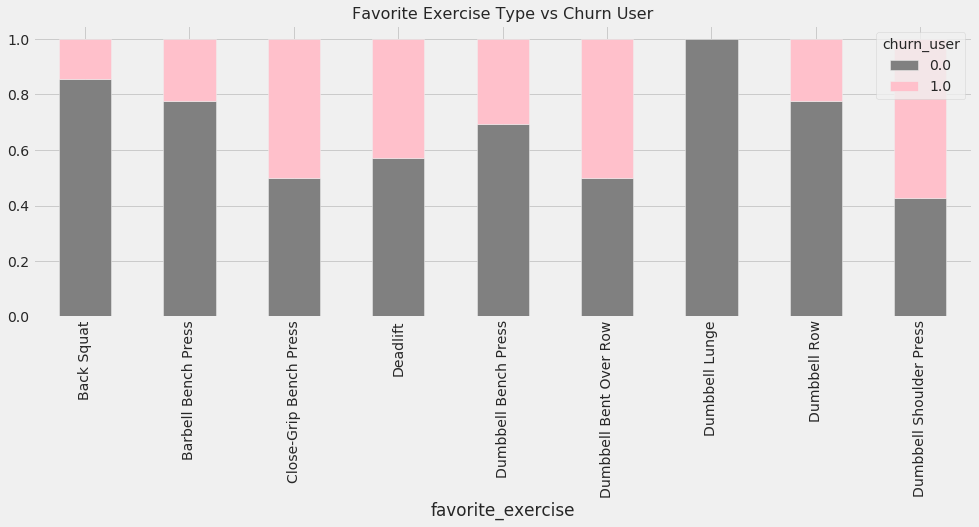

In [38]:
#high volumne/intensity VS. Favorite (mostly chosen) Exercise Types
# Favorite Exercise Type (mostly adopted) VS. Churn User
df1 = pd.crosstab(ob_peform['favorite_exercise'], ob_peform['churn_user'])
df1.div(df1.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'pink'])
plt.title('Favorite Exercise Type vs Churn User', fontsize = 16)
plt.show()


The user who frequently adopts Dumpbell Row is least likely to be churn users; by contrary, the users who frequently adopt close_grip Bench Press shoulder press is more likely to be churn users.

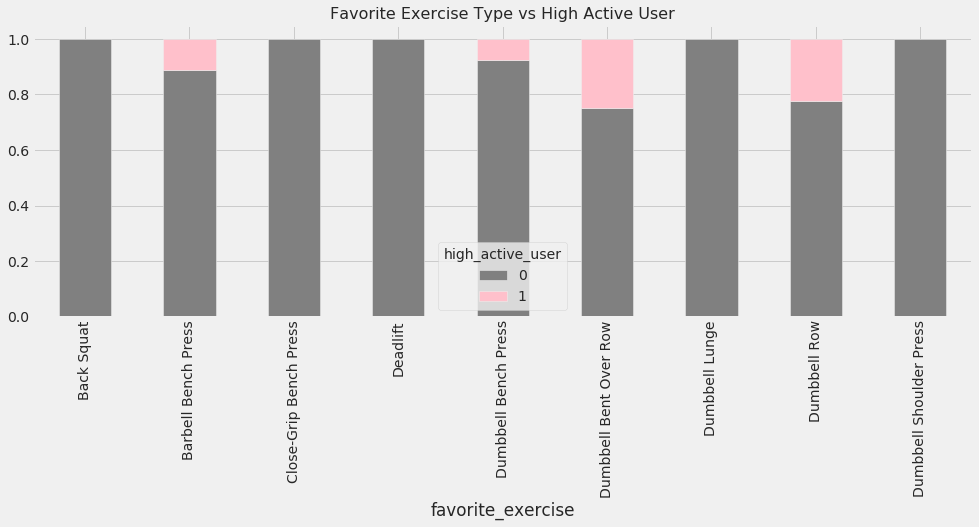

In [39]:
#high volumne/intensity VS. Favorite (mostly chosen) Exercise Types
df1 = pd.crosstab(ob_peform['favorite_exercise'], ob_peform['high_active_user'])
df1.div(df1.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'pink'])
plt.title('Favorite Exercise Type vs High Active User', fontsize = 16)
plt.show()

High_active_user seems has different meaning with churn_user and is more focused on the Dumbbell Bent Over Row and Dumbell Row.

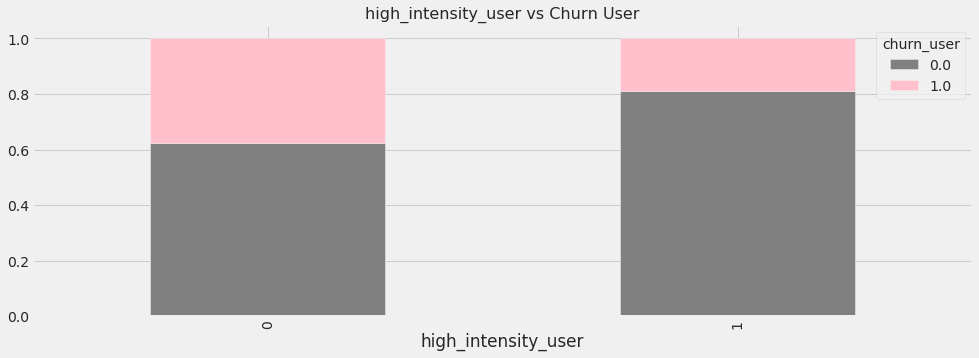

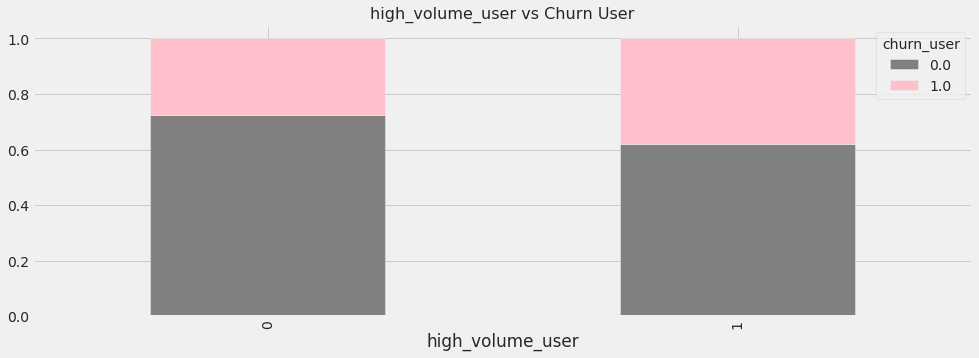

In [41]:
# Favorite Exercise Type (mostly adopted) VS. Churn User

df1 = pd.crosstab(ob_peform['high_intensity_user'], ob_peform['churn_user'])
df1.div(df1.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'pink'])
plt.title('high_intensity_user vs Churn User', fontsize = 16)

df2 = pd.crosstab(ob_peform['high_volume_user'], ob_peform['churn_user'])
df2.div(df2.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'pink'])
plt.title('high_volume_user vs Churn User', fontsize = 16)

#plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

(1)low intensity users are more likely to be churn users;
(2) volume has no obvious impact from the above figure.

# Churn VS. Volume/Intensity per Day

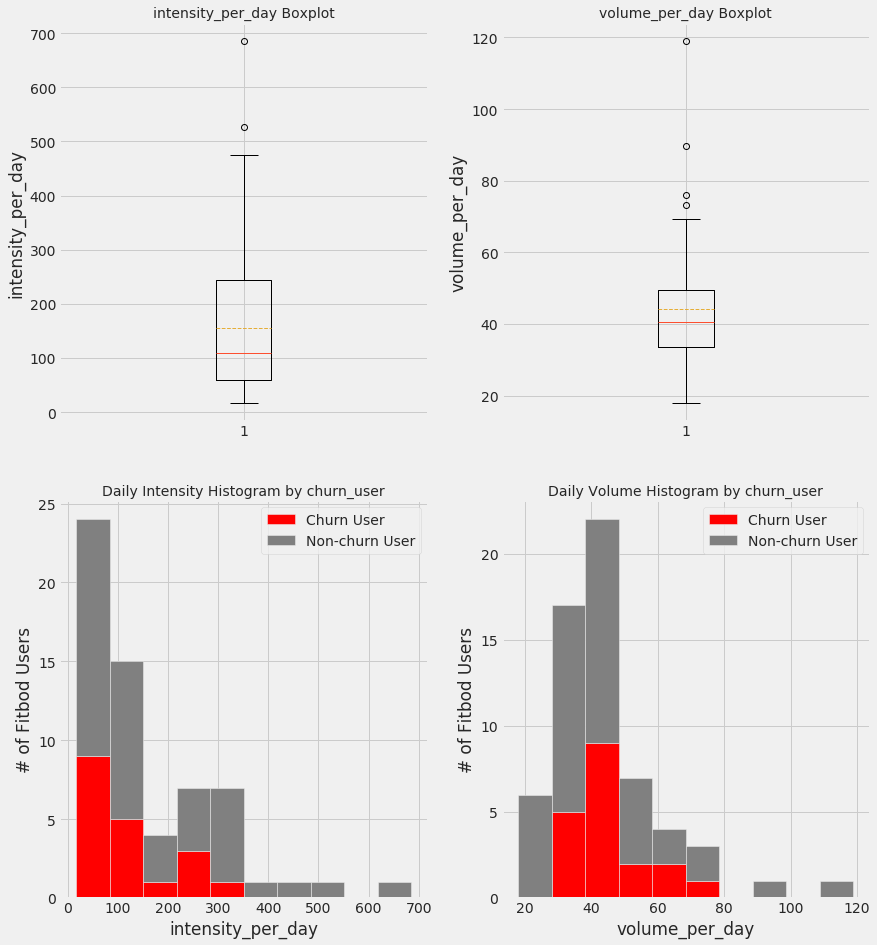

In [42]:
#Churn VS. Volume/Intensity per Day

plt.figure(figsize=[20,15])

plt.subplot(231)
plt.boxplot(x=ob_peform['intensity_per_day'], showmeans = True, meanline = True)
plt.title('intensity_per_day Boxplot',fontsize=14)
plt.ylabel('intensity_per_day')

plt.subplot(232)
plt.boxplot(ob_peform['volume_per_day'], showmeans = True, meanline = True)
plt.title('volume_per_day Boxplot',fontsize=14)
plt.ylabel('volume_per_day')


plt.subplot(234)
plt.hist(x = [ob_peform[ob_peform['churn_user']==1]['intensity_per_day'], ob_peform[ob_peform['churn_user']==0]['intensity_per_day']], 
         stacked=True, color = ['r','gray'],label = ['Churn User','Non-churn User'])
plt.title('Daily Intensity Histogram by churn_user', fontsize=14)
plt.xlabel('intensity_per_day')
plt.ylabel('# of Fitbod Users')
plt.legend()

plt.subplot(235)
plt.hist(x = [ob_peform[ob_peform['churn_user']==1]['volume_per_day'], ob_peform[ob_peform['churn_user']==0]['volume_per_day']], 
         stacked=True, color = ['r','gray'],label = ['Churn User','Non-churn User'])
plt.title('Daily Volume Histogram by churn_user', fontsize=14)
plt.xlabel('volume_per_day')
plt.ylabel('# of Fitbod Users')
plt.legend()

In [ ]:
#Save files for further use
#ob_peform.to_csv("ob_peform.csv",index=False,sep=',')

# 🎉 Let's go to the next part! Build the Magic Churn Model together!